# NYC 311 Service Requests Data Pipeline

*Library + jobs to fetch, cache, and analyze NYC 311 service request data.*

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# As Jobs

## LTP Pipeline

In [ ]:
# retrieve for one day only:
%cd -q ..
!python -m hbc.jobs.dispatch  \
      --job-name=job_poll_nyc_311 \
      --as-of=20091231 \
      --incremental=True \
      --log-level=INFO      
%cd -q notebooks/

In [ ]:
# restore cache integrity for the last missing dates
%cd -q ..
!python -m hbc.jobs.dispatch  \
      --job-name=job_poll_nyc_311 \
      --as-of=20091231 \
      --incremental=false \
      --log-level=INFO \
      --last-missing-dates=5
%cd -q notebooks/

## Analytics

In [ ]:
%cd -q ..
!python -m hbc.jobs.dispatch  \
      --job-name=job_analysis_nyc_311 \
      --as-of=20091231 \
      --log-level=INFO \
      --n-worst=10 \
      --n-best=10 \
      --n-days=10
%cd -q notebooks/

***

# As Library 

### Imports

In [ ]:
import sys
from pathlib import Path

p = str(Path.cwd().parent) # one dir up
if p not in sys.path:
    sys.path.insert(0, p)

In [ ]:
import pandas as pd
import os
import numpy as np
import logging
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Api

In [ ]:
from hbc import app_context, DataContainer, utils as ul

In [ ]:
from hbc.quant.analysis import AnalyticalEngine
from hbc.quant.plots import PlotEngine

In [ ]:
app_context

## Logging

In [ ]:
# Console-only (no file writes):
ul.conf_log(level=logging.DEBUG, console=True, file=False, reset_handlers=True)

# File-only (no console output at all):
ul.conf_log(level=logging.INFO, console=False, file=True, reset_handlers=True)

# Both:
ul.conf_log(level=logging.INFO, console=True, file=True, reset_handlers=True)

## DataContainer

In [ ]:
dc = DataContainer('nyc_open_data_311_service_requests')

In [ ]:
# we retrieve for app_context.as_of
dc.get()

In [ ]:
app_context.as_of = '20091231'

In [ ]:
dc.get()

In [ ]:
dc.to_cache()

In [ ]:
dc.from_cache().head()

In [ ]:
', '.join(dc.all_cached_dates)

## Analytics

In [ ]:
df = dc.df

In [ ]:
cols = ul.cols_as_named_tuple(df)

In [ ]:
df = df[~df[cols.DROP_FLAG]]

In [ ]:
df["hbc_days_to_close"] = (
    pd.to_datetime(df[cols.closed_date])
    - pd.to_datetime(df[cols.created_date])
).dt.days.astype("Int64")
cols = ul.cols_as_named_tuple(df)

In [ ]:
m = df[cols.hbc_days_to_close] == 0
df_closed_not_same_day = df[~m]

In [ ]:
path = ul.path_to_str(
                ul.mk_dir(ul.get_dir_analytics() / "plots")
                / "closed_requests_by_location.html"
            )
_ = PlotEngine.plot_geo_map(
            df=df_closed_not_same_day,
            col_latitude=cols.latitude,
            col_longitude=cols.longitude,
            aggregation="count",
            round_precision=3,
            cluster=True,
            start_zoom=11,
            tiles="CartoDB positron",
            savepath= path
        )
print(path)

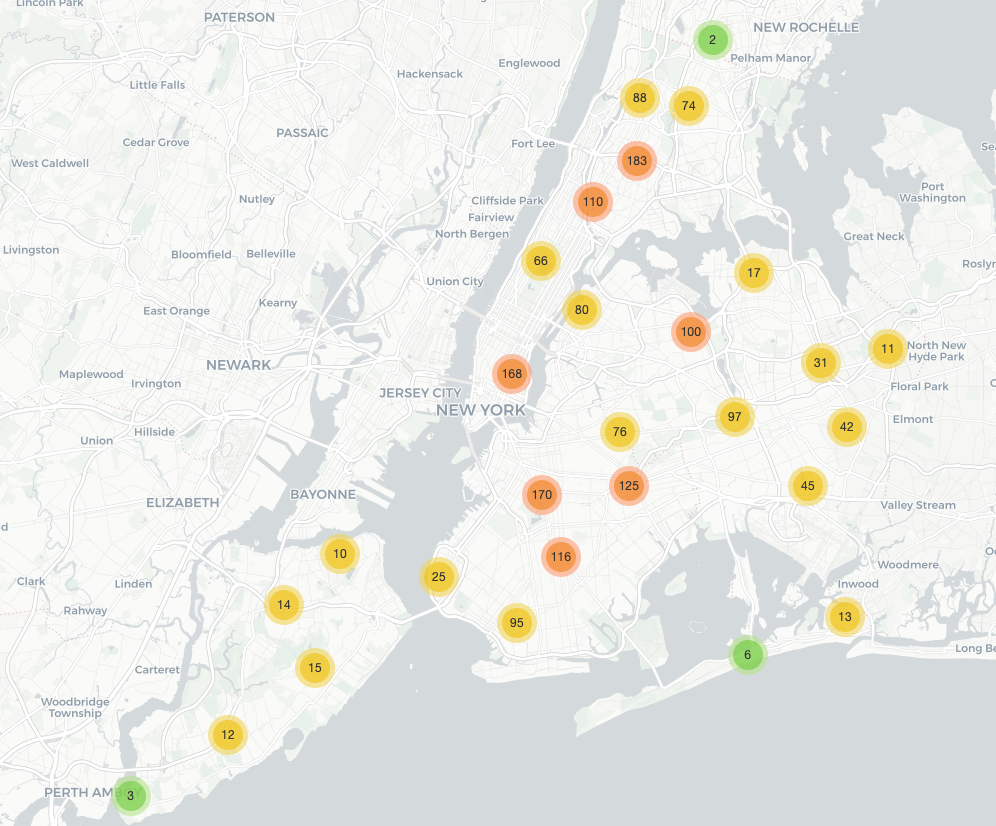

In [ ]:
# by agency
res = AnalyticalEngine.descriptive_stats(
    n_best=10,
    n_worst=10,
    df=df_closed_not_same_day,
    col_metric=cols.hbc_days_to_close,
    group=[
        cols.agency,
        cols.agency_name,
    ],
)


In [ ]:
res.keys()

In [ ]:
res['worst']